In [1]:
import pandas as pd
import numpy as np
import random
import copy

In [2]:
seed = 42

In [3]:
data = pd.read_csv('../GeneralData/ETTh1.csv')
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [4]:
import torch.nn as nn

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
feature_size = 7

In [6]:
# LSTM은 Encoder와 Decoder를 각각 구현해야 한다.
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 14
        self.input_size = feature_size
        self.encoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        # batch_first = True로 인해서 (batch,seq,feature)순으로 입력 받는다.
        # 그 당시에 알고 있는 정보가 없으므로 input_size = 0
        self.decoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        
        
        self.output_layer = nn.Linear(self.hidden_size, 1).to(device)
    def forward(self,x):
        x = x.to(device)
        self.encoder.flatten_parameters()
        self.decoder.flatten_parameters()
        outputs,(hidden,cell) = self.encoder(x)
        
        # 현재 prediction_length = 1이기 때문에, 반복문을 돌리지 않아도 됨
        # but 길어진다면 반복문을 돌려서 output값을 얻어야 한다.
        # 기본적으로 output = hidden state이기에 output을 생성할
        # Fully Connected Layer가 필요하게 된다.
        # 이때 decoder_output의 사이즈는 (batch,seq,hidden) 이다
        # 중간에 seq가 들어오게 되는 이유는 입력 크기 만큼 lstm이 반복되기 때문에
        # seq=1 이기 때문에 squeeze를 수행
        
        hidden = hidden.to(device)
        cell = cell.to(device)
        decoder_input = torch.zeros([x.size(0),1,x.size(2)]).to(device)
        decoder_out,(hidden,cell) = self.decoder(decoder_input,(hidden,cell))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.output_layer(decoder_out)
        
        return out

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch

In [8]:
device = torch.device("cuda:0")

In [9]:
sequence_length = 24 # 1일
pred_length = 1 # 1시간
split = int(len(data)*0.8)

In [10]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length):
        # 시간데이터를 제외하고 추출
        seq_list.append(x.iloc[i:i+sequence_length,1:].values)
        # OT만 추출
        target_list.append(x.iloc[i+sequence_length,-1])
        
    return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)

In [11]:
train = data.iloc[:split]
val = data.iloc[split:]

X_train, y_train = seq_data(train,sequence_length,pred_length)
X_val, y_val = seq_data(val,sequence_length,pred_length)

tr_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val,y_val)

training =  DataLoader(tr_dataset,batch_size = 64)
validation = DataLoader(val_dataset,batch_size = 64)

/tmp/ipykernel_1130898/2507691695.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)


In [12]:
torch.cuda.is_available()

True

In [13]:
X_train.size() # 168개의 sequence_length 7개의 Feature

torch.Size([13912, 24, 7])

* 잘 데이터가 구성된 걸 확인 가능

In [14]:
train.iloc[:169]

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
164,2016-07-07 20:00:00,11.119,4.153,7.427,1.919,3.746,1.675,32.922001
165,2016-07-07 21:00:00,10.449,3.282,7.107,1.279,3.594,1.706,33.625999
166,2016-07-07 22:00:00,10.516,3.885,7.356,1.599,3.168,1.675,32.640999
167,2016-07-07 23:00:00,11.855,5.358,8.884,3.198,3.076,1.553,31.586000


In [15]:
X_train

tensor([[[  5.8270,   2.0090,   1.5990,  ...,   4.2030,   1.3400,  30.5310],
         [  5.6930,   2.0760,   1.4920,  ...,   4.1420,   1.3710,  27.7870],
         [  5.1570,   1.7410,   1.2790,  ...,   3.7770,   1.2180,  27.7870],
         ...,
         [  5.0900,   2.9470,   2.3810,  ...,   2.6800,   1.5230,  18.0090],
         [  4.8230,   2.9470,   2.2030,  ...,   2.6190,   1.5230,  18.0090],
         [  4.6220,   2.8800,   2.1320,  ...,   2.4670,   1.4920,  19.7680]],

        [[  5.6930,   2.0760,   1.4920,  ...,   4.1420,   1.3710,  27.7870],
         [  5.1570,   1.7410,   1.2790,  ...,   3.7770,   1.2180,  27.7870],
         [  5.0900,   1.9420,   1.2790,  ...,   3.8070,   1.2790,  25.0440],
         ...,
         [  4.8230,   2.9470,   2.2030,  ...,   2.6190,   1.5230,  18.0090],
         [  4.6220,   2.8800,   2.1320,  ...,   2.4670,   1.4920,  19.7680],
         [  5.2240,   3.0810,   2.7010,  ...,   2.4370,   1.5230,  21.1040]],

        [[  5.1570,   1.7410,   1.2790,  ...

In [16]:
y_train

tensor([[[21.1040]],

        [[19.6970]],

        [[20.0490]],

        ...,

        [[ 4.2910]],

        [[ 6.2610]],

        [[ 3.9390]]], device='cuda:0')

In [17]:
from torch.optim import Adam

In [18]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
model = LSTM().to(device)
optimizer = Adam(model.parameters(),lr = 1e-4)
num_epochs = 200
n = len(training)

In [19]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [20]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[200] running accumulative loss across all batches: 305.561
changed
Epoch [2]/[200] running accumulative loss across all batches: 298.734
changed
Epoch [3]/[200] running accumulative loss across all batches: 288.643
changed
Epoch [4]/[200] running accumulative loss across all batches: 276.056
changed
Epoch [5]/[200] running accumulative loss across all batches: 262.479
changed
Epoch [6]/[200] running accumulative loss across all batches: 249.488
changed
Epoch [7]/[200] running accumulative loss across all batches: 238.562
changed
Epoch [8]/[200] running accumulative loss across all batches: 229.283
changed
Epoch [9]/[200] running accumulative loss across all batches: 221.108
changed
Epoch [10]/[200] running accumulative loss across all batches: 213.794
changed
Epoch [11]/[200] running accumulative loss across all batches: 207.141
changed
Epoch [12]/[200] running accumulative loss across all batches: 200.915
changed
Epoch [13]/[200] running accumulative loss across all batches

Epoch [106]/[200] running accumulative loss across all batches: 23.286
changed
Epoch [107]/[200] running accumulative loss across all batches: 22.891
changed
Epoch [108]/[200] running accumulative loss across all batches: 22.507
changed
Epoch [109]/[200] running accumulative loss across all batches: 22.128
changed
Epoch [110]/[200] running accumulative loss across all batches: 21.759
changed
Epoch [111]/[200] running accumulative loss across all batches: 21.396
changed
Epoch [112]/[200] running accumulative loss across all batches: 21.041
changed
Epoch [113]/[200] running accumulative loss across all batches: 20.693
changed
Epoch [114]/[200] running accumulative loss across all batches: 20.353
changed
Epoch [115]/[200] running accumulative loss across all batches: 20.020
changed
Epoch [116]/[200] running accumulative loss across all batches: 19.693
changed
Epoch [117]/[200] running accumulative loss across all batches: 19.373
changed
Epoch [118]/[200] running accumulative loss across a

In [21]:
from captum.attr import IntegratedGradients,NoiseTunnel

In [22]:
for val in validation:
    print(val[0].size())

torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 

In [23]:
test = next(iter(validation))[0][0] # 하나의 sample에 대해서 진행
test = test.unsqueeze(0)
test.size()

torch.Size([1, 24, 7])

In [24]:
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
attr_score = nt_ig.attribute(test)
attr_score

tensor([[[ 6.9378e-05, -1.6521e-04, -2.0848e-05, -1.2849e-04,  2.1574e-04,
          -6.2713e-06, -4.5260e-05],
         [ 6.3689e-04, -1.0354e-04, -1.8933e-04, -1.8875e-04,  1.2672e-04,
          -2.0883e-05, -3.2158e-04],
         [ 1.0039e-03,  3.9087e-05, -3.6686e-04, -8.5763e-05, -1.9005e-04,
          -1.6543e-05, -1.8430e-04],
         [ 1.9780e-03,  2.1498e-04, -8.6781e-04, -4.4082e-04, -5.0452e-04,
          -3.6249e-05, -4.1650e-05],
         [ 3.1466e-03,  5.1307e-04, -2.0021e-03, -2.3057e-04, -9.0609e-04,
          -2.7951e-04, -6.0087e-04],
         [ 5.1103e-03,  4.4476e-04, -2.9323e-03, -1.7064e-04, -1.9027e-03,
          -1.9514e-04, -9.7162e-04],
         [ 7.6119e-03,  1.1085e-03, -4.9240e-03, -8.9371e-05, -2.3737e-03,
          -1.0398e-04, -1.0151e-03],
         [ 9.4508e-03,  1.8695e-03, -6.4506e-03, -5.2429e-04, -3.8701e-03,
          -7.3050e-04, -1.4218e-03],
         [ 9.2748e-03,  2.5247e-03, -7.0785e-03, -8.2931e-04, -5.1245e-03,
           1.4015e-04, -3.923

In [25]:
attr_score.size()

torch.Size([1, 24, 7])

In [26]:
attr_score.to("cpu")

tensor([[[ 6.9378e-05, -1.6521e-04, -2.0848e-05, -1.2849e-04,  2.1574e-04,
          -6.2713e-06, -4.5260e-05],
         [ 6.3689e-04, -1.0354e-04, -1.8933e-04, -1.8875e-04,  1.2672e-04,
          -2.0883e-05, -3.2158e-04],
         [ 1.0039e-03,  3.9087e-05, -3.6686e-04, -8.5763e-05, -1.9005e-04,
          -1.6543e-05, -1.8430e-04],
         [ 1.9780e-03,  2.1498e-04, -8.6781e-04, -4.4082e-04, -5.0452e-04,
          -3.6249e-05, -4.1650e-05],
         [ 3.1466e-03,  5.1307e-04, -2.0021e-03, -2.3057e-04, -9.0609e-04,
          -2.7951e-04, -6.0087e-04],
         [ 5.1103e-03,  4.4476e-04, -2.9323e-03, -1.7064e-04, -1.9027e-03,
          -1.9514e-04, -9.7162e-04],
         [ 7.6119e-03,  1.1085e-03, -4.9240e-03, -8.9371e-05, -2.3737e-03,
          -1.0398e-04, -1.0151e-03],
         [ 9.4508e-03,  1.8695e-03, -6.4506e-03, -5.2429e-04, -3.8701e-03,
          -7.3050e-04, -1.4218e-03],
         [ 9.2748e-03,  2.5247e-03, -7.0785e-03, -8.2931e-04, -5.1245e-03,
           1.4015e-04, -3.923

In [27]:
plot_attribution = attr_score.to("cpu").detach().numpy()
plot_attribution

array([[[ 6.93783001e-05, -1.65212275e-04, -2.08484715e-05,
         -1.28493447e-04,  2.15740208e-04, -6.27127449e-06,
         -4.52597895e-05],
        [ 6.36888226e-04, -1.03544685e-04, -1.89329886e-04,
         -1.88746256e-04,  1.26716182e-04, -2.08832133e-05,
         -3.21575223e-04],
        [ 1.00388846e-03,  3.90868016e-05, -3.66863677e-04,
         -8.57633341e-05, -1.90053303e-04, -1.65425911e-05,
         -1.84301554e-04],
        [ 1.97800723e-03,  2.14976425e-04, -8.67807946e-04,
         -4.40823940e-04, -5.04517668e-04, -3.62488592e-05,
         -4.16495242e-05],
        [ 3.14663642e-03,  5.13074300e-04, -2.00209507e-03,
         -2.30565873e-04, -9.06086066e-04, -2.79509191e-04,
         -6.00872258e-04],
        [ 5.11032896e-03,  4.44755921e-04, -2.93226440e-03,
         -1.70639470e-04, -1.90273110e-03, -1.95142221e-04,
         -9.71618366e-04],
        [ 7.61188007e-03,  1.10852779e-03, -4.92403379e-03,
         -8.93714512e-05, -2.37371532e-03, -1.03983393e-04

In [28]:
plot_attribution = plot_attribution.reshape(-1,7)

In [29]:
column = data.columns[1:]
column

Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

In [30]:
attr_df = pd.DataFrame(plot_attribution,columns=column)

In [31]:
attr_df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,0.000069,-0.000165,-0.000021,-0.000128,0.000216,-0.000006,-0.000045
1,0.000637,-0.000104,-0.000189,-0.000189,0.000127,-0.000021,-0.000322
2,0.001004,0.000039,-0.000367,-0.000086,-0.000190,-0.000017,-0.000184
3,0.001978,0.000215,-0.000868,-0.000441,-0.000505,-0.000036,-0.000042
4,0.003147,0.000513,-0.002002,-0.000231,-0.000906,-0.000280,-0.000601
5,0.005110,0.000445,-0.002932,-0.000171,-0.001903,-0.000195,-0.000972
6,0.007612,0.001109,-0.004924,-0.000089,-0.002374,-0.000104,-0.001015
7,0.009451,0.001870,-0.006451,-0.000524,-0.003870,-0.000730,-0.001422
8,0.009275,0.002525,-0.007078,-0.000829,-0.005124,0.000140,-0.000392
9,0.013073,0.002904,-0.010300,-0.001023,-0.004451,-0.001288,-0.000849


# 특징 관찰

### our goal -> 특정 시간대를 추출해내는 방법을 고안

In [32]:
next(iter(validation))[1][0]

tensor([[3.3060]], device='cuda:0')

* 전체 Attribution DataFrame이 예측값을 나눈것으로 보임
    * 현재 하나의 Sample Batch의 첫번째 Sample에 대해서 Attribution을 구했는데
    하나의 DataFrame이 나왔음

In [33]:
attr_df.sum(axis=0).sum()

4.279091741669246

## 전체 피쳐의 평균 영향
* 각 피쳐가 미치는 영향도를 구할 수 있음

<AxesSubplot: >

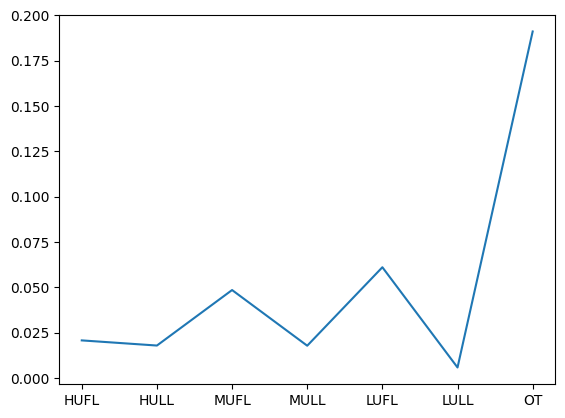

In [34]:
attr_df.abs().mean(axis=0).plot()

## 각 시간 별 영향 추이
* 각 시간별로 중요한 정도를 계산할 수 있음

<AxesSubplot: >

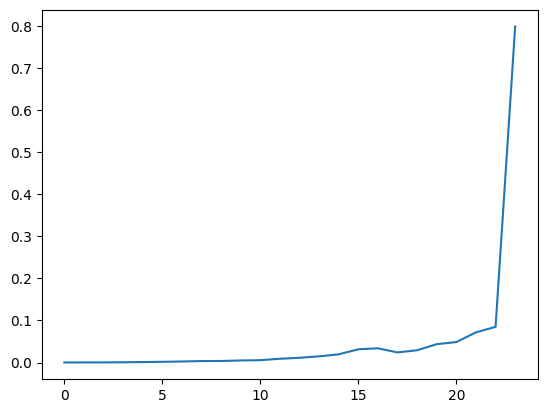

In [35]:
attr_df.abs().mean(axis = 1).plot()

## 각 피쳐별로 시간에 따른 영향 추이

<AxesSubplot: >

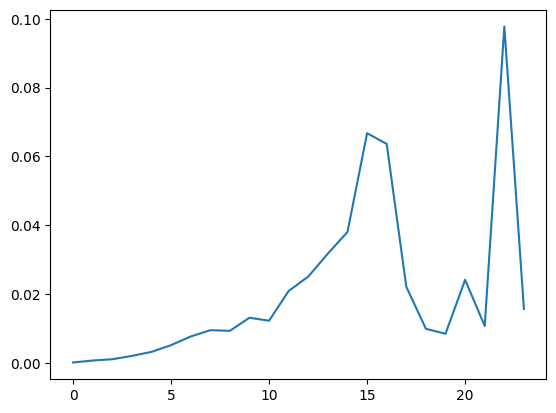

In [36]:
attr_df['HUFL'].abs().plot()

<AxesSubplot: >

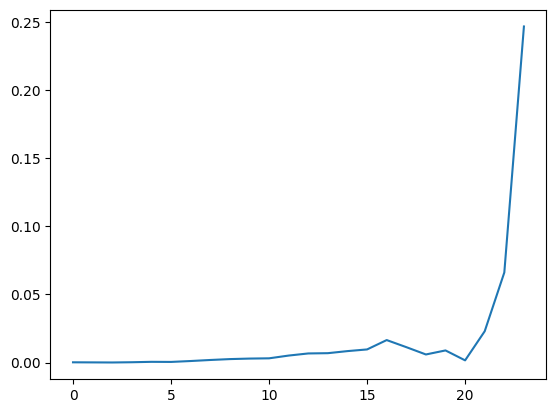

In [37]:
attr_df['HULL'].abs().plot()

<AxesSubplot: >

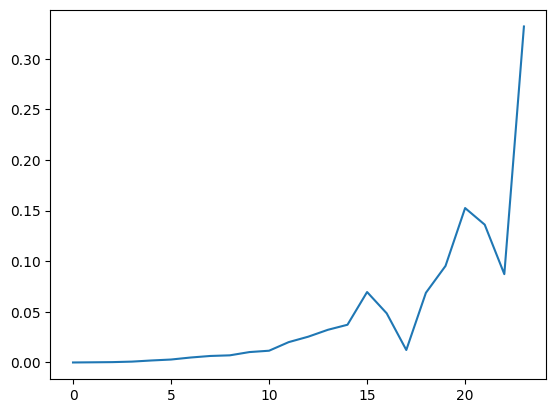

In [38]:
attr_df['MUFL'].abs().plot()

<AxesSubplot: >

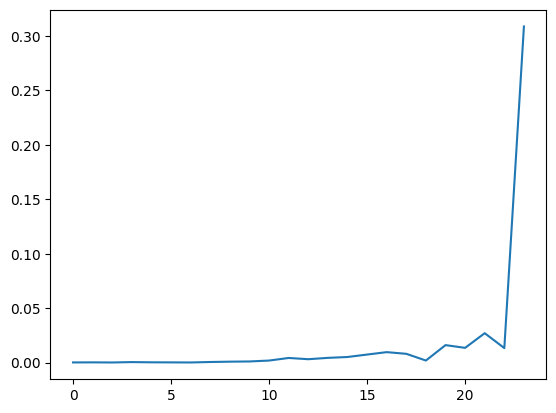

In [39]:
attr_df['MULL'].abs().plot()

<AxesSubplot: >

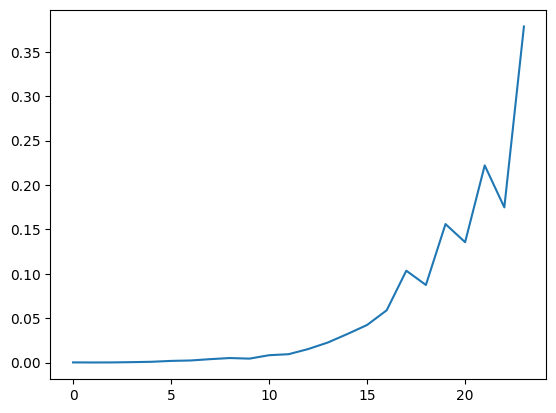

In [40]:
attr_df['LUFL'].abs().plot()

<AxesSubplot: >

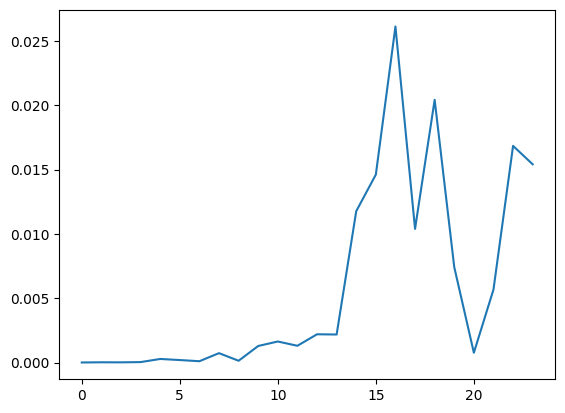

In [41]:
attr_df['LULL'].abs().plot()

<AxesSubplot: >

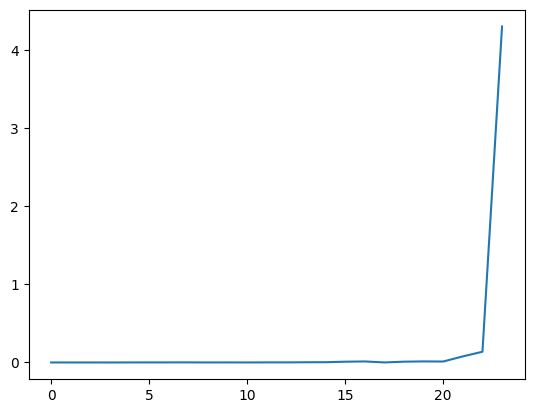

In [42]:
attr_df['OT'].abs().plot()

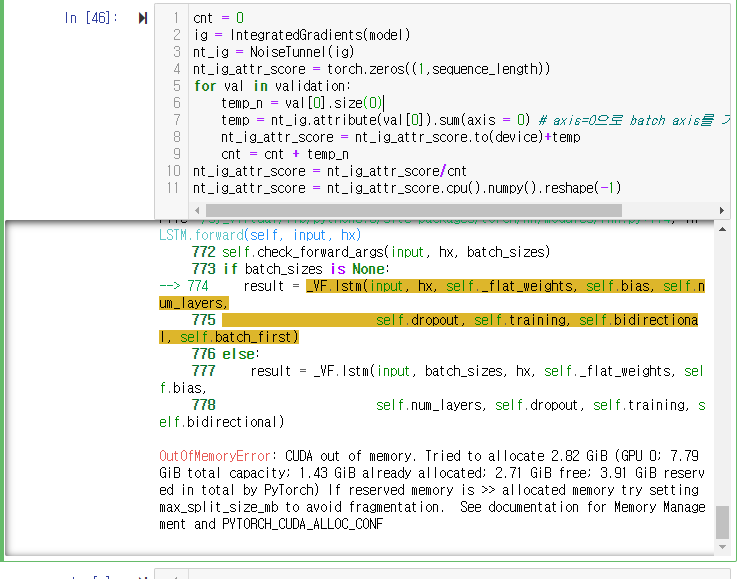

In [43]:
sequence_length

24

In [44]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = np.zeros((1,sequence_length))
for val_batch in validation:
    temp_n = val_batch[0].size(0)
    for val in val_batch[0]: # 하나의 배치에 대해서 for문
        val = val.unsqueeze(0)
        temp = nt_ig.attribute(val).abs()
        # 각 attribution score의 절대값을 합한다.
        # 이로써 각 시간별로 영향도를 구함
        # 이 부분이 abs를 씌우는게 절대적인 영향을 반영하는데에 맞는 것 같다.
        # 이전까진 씌우지 않았음
        temp = temp.to("cpu").detach().numpy().reshape(-1,feature_size)
        temp = temp.sum(axis=1) 
        nt_ig_attr_score = nt_ig_attr_score+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt

In [45]:
nt_ig_attr_score.reshape(-1)

array([2.71980058e-03, 3.27005856e-03, 4.01799693e-03, 5.14853737e-03,
       6.75736091e-03, 8.95064528e-03, 1.17695068e-02, 1.52995278e-02,
       1.97971822e-02, 2.51821696e-02, 3.20829631e-02, 4.08490911e-02,
       5.21172519e-02, 6.61415382e-02, 8.44212056e-02, 1.07787246e-01,
       1.36832960e-01, 1.73278767e-01, 2.19116859e-01, 2.76837270e-01,
       3.50203650e-01, 5.63912114e-01, 1.28368066e+00, 8.44180220e+00])

<AxesSubplot: >

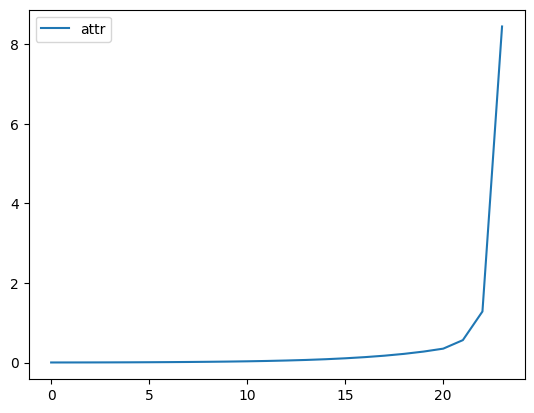

In [46]:
total_mean_attr_df = pd.DataFrame({"attr":nt_ig_attr_score.reshape(-1)})
total_mean_attr_df.plot()

In [ ]:
for val_batch in validation:
    print(val_batch[0])
    for val in val_batch[0]:
        print(val)